In [1]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

C:\Users\zhikang.du\AppData\Local\conda\conda\envs\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [2]:
img_path = 'data/cats_and_dogs_small/test/cats/cat.1700.jpg'

In [3]:
from keras.preprocessing import image
import numpy as np

In [4]:
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

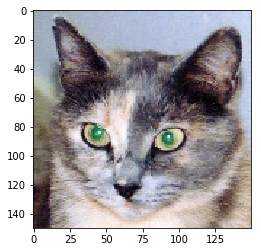

In [6]:
plt.imshow(img_tensor[0])
plt.show()

In [7]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [8]:
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
__________

In [9]:
activations = activation_model.predict(img_tensor)

In [10]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


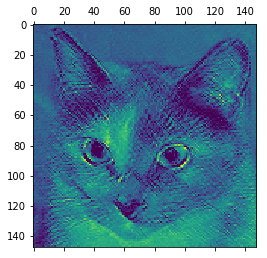

In [11]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

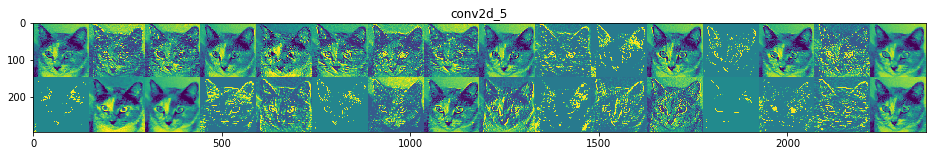

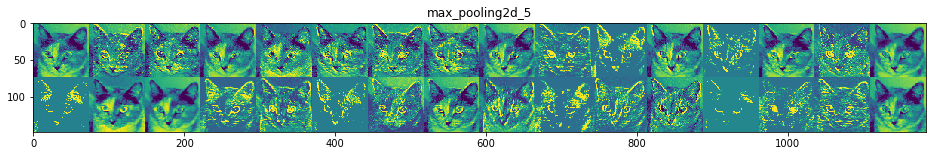

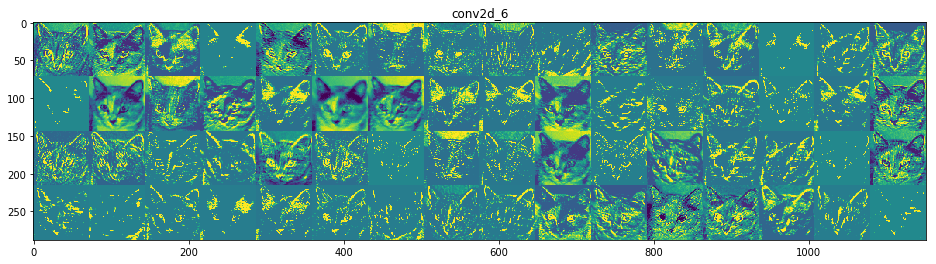

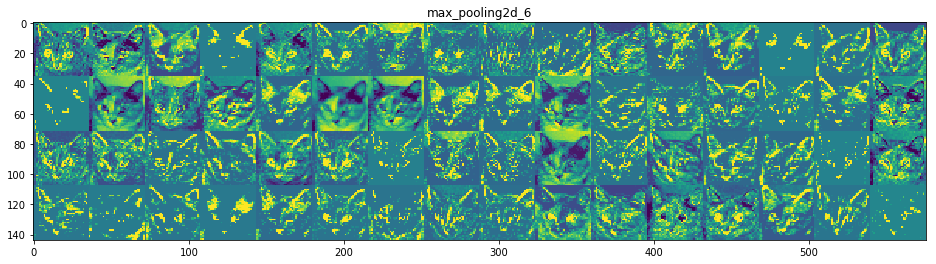

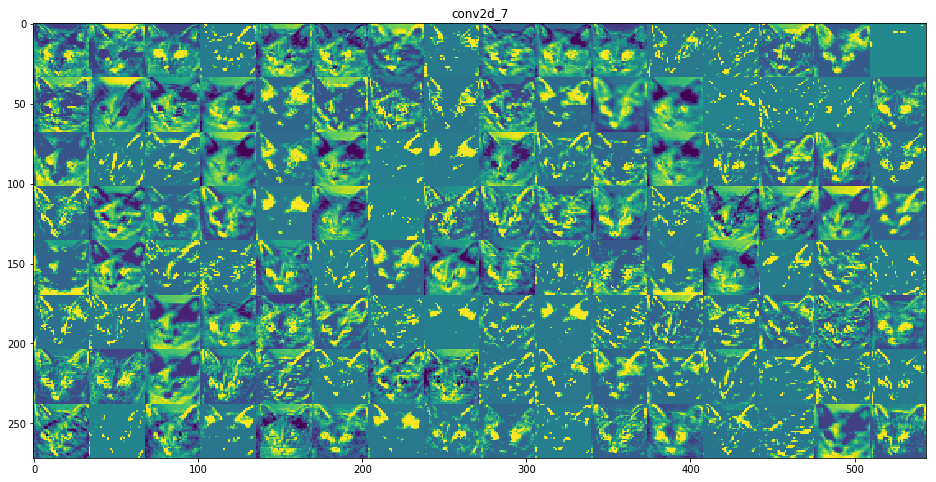

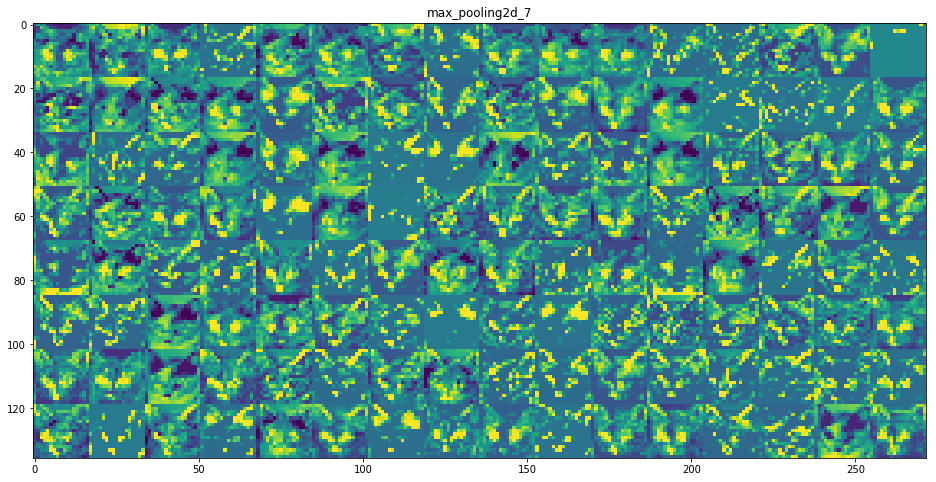

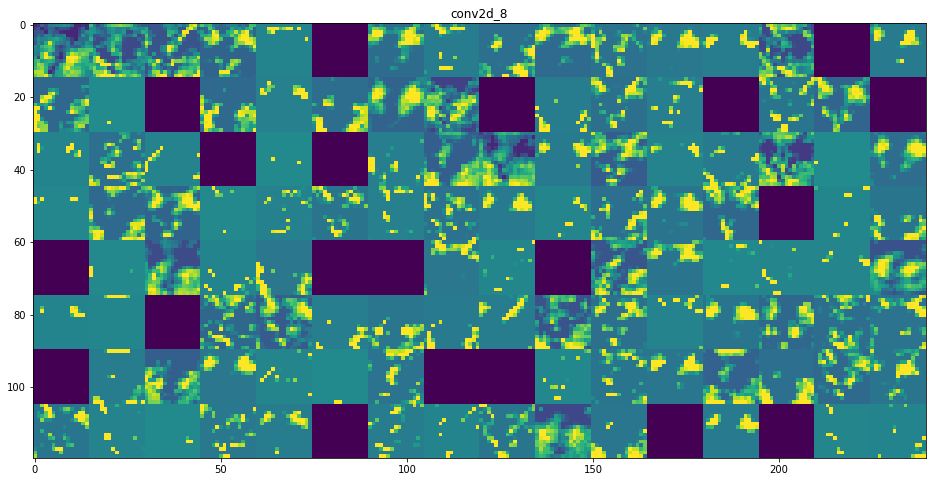

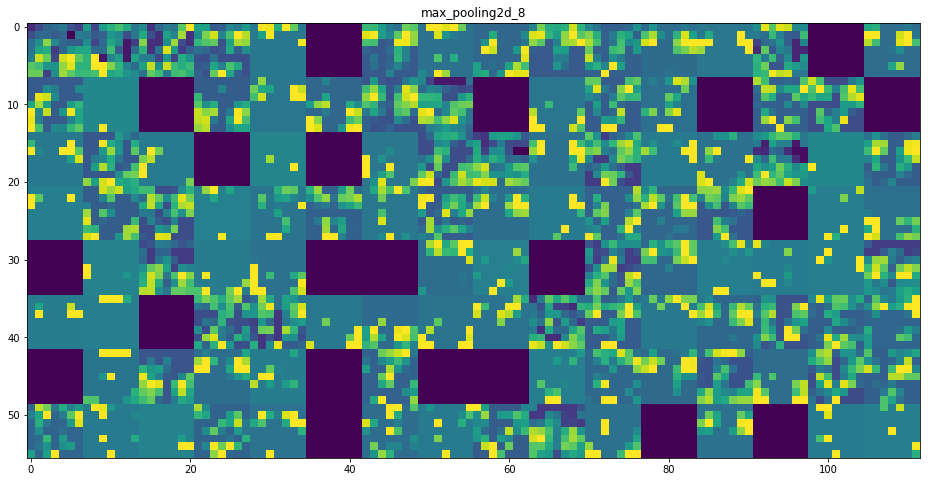

In [14]:
# 层的名称，这样可以将这些名称画到图中
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 显示特征图
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]  # 特征图中的特征个数
    
    size = layer_activation.shape[1]    # 特征图形状为 (1, size, size, n_features)
    
    n_cols = n_features // images_per_row    # 在这个矩阵中将激活通道平铺
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    # 将每个过滤器平铺到一个大的水平网格中
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # 对特征图进行后期处理，使其更加美观
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
plt.show()

In [15]:
from keras.applications import VGG16
from keras import backend as K

In [17]:
model = VGG16(weights='imagenet',
              include_top=False)

58892288/58889256 [==============================] - 247s 4us/step


In [18]:
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [19]:
grads = K.gradients(loss, model.input)[0]

In [20]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [21]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [22]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

In [23]:
step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [24]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [27]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 +128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

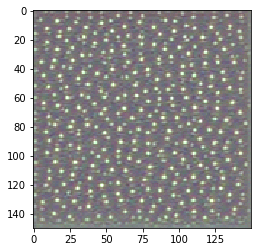

In [28]:
plt.imshow(generate_pattern('block3_conv1', 0))

In [31]:
layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start : horizontal_end, vertical_start : vertical_end, :] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results)

KeyboardInterrupt: 

In [32]:
from keras.applications.vgg16 import VGG16

K.clear_session()

model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 2292s 4us/step


In [34]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [35]:
preds = model.predict(x)
preds

array([[1.85476114e-12, 1.93137848e-15, 2.07745757e-14, 3.42279102e-14,
        1.05806694e-13, 1.42196368e-13, 2.08408950e-14, 5.68434622e-13,
        2.77827552e-14, 3.39526768e-10, 1.34639730e-15, 1.82976460e-15,
        2.42098555e-15, 1.17657715e-15, 2.81528002e-14, 5.03507927e-14,
        1.98798074e-14, 3.42301294e-14, 1.16949473e-13, 4.72278678e-15,
        1.38854391e-14, 2.01245739e-11, 1.55720506e-11, 6.16561177e-11,
        3.28794663e-13, 2.03501173e-14, 1.90924598e-14, 4.44445684e-15,
        2.21051848e-14, 2.96055193e-14, 6.30166001e-15, 8.88032148e-16,
        5.19429275e-15, 9.36634559e-13, 3.32239379e-12, 7.30303676e-13,
        2.49901206e-12, 1.16683220e-13, 4.12781551e-14, 3.99397312e-12,
        1.20640844e-14, 8.87710858e-15, 4.57984243e-14, 3.19204472e-12,
        1.56102395e-14, 2.21846887e-13, 4.32160885e-14, 3.55765677e-12,
        2.86051460e-10, 1.77018511e-10, 4.09336974e-12, 9.07348721e-08,
        9.57803342e-15, 7.20486970e-14, 1.87102903e-14, 8.127624

In [36]:
np.argmax(preds[0])

386

In [45]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

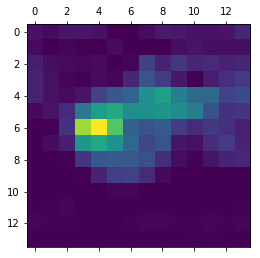

In [46]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [47]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('elephant_cam.jpg', superimposed_img)

True

![](elephant_cam.jpg)